## Tutorial 3 - Autoencoder Continued Training

In this example, we will demonstrate how a model that has been pretrained can be continued to train with new data. This is useful when you have a model that has been trained on a large dataset, and you want to fine-tune it to a new dataset. BUT, we demonstrate that this is not always a good idea.

In [1]:
import numpy as np

### Load our pretrained model

In [2]:
from tensorflow import keras

pretrained_model = keras.models.load_model('initially_trained_autoencoder.h5')

2023-04-30 20:54:41.864382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-30 20:54:47.492744: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load our new symbol and test the autoencoder on this new symbol

1/1 [==============================] - 0s 150ms/step
(1, 784)


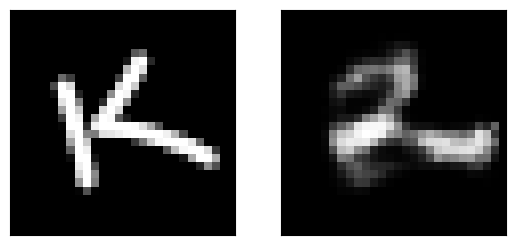

In [3]:
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image


####################################
# load a sample image
image = tf.keras.utils.load_img('newimg_1.png', target_size=(28, 28), color_mode = "grayscale")


####################################
# predict an image from this sample
input_arr = tf.keras.utils.img_to_array(image)
input_arr = input_arr/ 255 # normalize between 0 and 1
input_arr = input_arr.reshape(784)
input_arr = np.array([input_arr])  # Convert single image to a batch with one image in it

predictions = pretrained_model.predict(input_arr)
print(predictions.shape)


#####################################
# display the two images side by side
# 
plt.subplot(1,2,1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(image, cmap="gray")


plt.subplot(1,2,2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(predictions[0].reshape(28,28), cmap="gray")


plt.show()

As we can, this autoencoder doesn't do a good job with this new symbol.

In [4]:

####################################
# load the 5 images 


image_filenames = ['newimg_1.png', 'newimg_2.png', 'newimg_3.png', 'newimg_4.png', 'newimg_5.png']
images = []
for filename in image_filenames:
    image = tf.keras.utils.load_img(filename, target_size=(28, 28), color_mode='grayscale')
    images.append(image)

# Convert the images to arrays and create 135 copies of each image
bad_images = []
for image in images:
    input_arr = tf.keras.utils.img_to_array(image)
    input_arr = input_arr / 255
    input_arr = input_arr.reshape(784)
    input_arr = np.array([input_arr])
    input_arr = input_arr.reshape(784)
    bad_images.extend([input_arr.copy() for _ in range(135)])



### Try to continue training the model on the original 10 digits and with the new symbol mixed in   

Let's try to retrain the original model with a mix of the new symbol and the original 10. Our goal it so avoid retraining with the entire original test test, and instead only use a small subset of the original test set.

In [5]:
from tensorflow.keras.datasets import mnist


# load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print(train_images.shape)
print(test_images.shape)

# Flatten the images for a autoencoder input (28x28 is 784 -- therfore, input is 784 neurons)
train_images = np.reshape(train_images, (-1, 784))
test_images = np.reshape(test_images, (-1, 784))
print(train_images.shape)
print(test_images.shape)

# Normalize data - since it's grayscale, we can divide by 255 to get each pixel between 0 and 1
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

(60000, 28, 28)
(10000, 28, 28)
(60000, 784)
(10000, 784)


In [6]:


np.random.shuffle(train_images)


new_image_set = np.vstack((train_images[:2000], bad_images))
np.random.shuffle(new_image_set)

new_images_train = new_image_set[int(len(new_image_set)*.8):]
new_images_test = new_image_set[int(len(new_image_set)*.2):]

In [7]:
from tensorflow import keras
updated_model = keras.models.load_model('initially_trained_autoencoder.h5')

from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training

# Train the autoencoder with MNIST data
early_stop = EarlyStopping(monitor='loss', patience=3, verbose=1)
history = updated_model.fit(
    x=new_images_train, # For autoencoders, both the input and the target are the same
    y=new_images_train, 
    epochs=15, 
    batch_size=128,
    shuffle=True, 
    validation_data=(new_images_test, new_images_test),
    callbacks=[early_stop]
)

Epoch 1/15
5/5 [==============================] - 1s 89ms/step - loss: 0.1246 - val_loss: 0.1107
Epoch 2/15
5/5 [==============================] - 0s 37ms/step - loss: 0.1049 - val_loss: 0.0987
Epoch 3/15
5/5 [==============================] - 0s 36ms/step - loss: 0.0936 - val_loss: 0.0935
Epoch 4/15
5/5 [==============================] - 0s 36ms/step - loss: 0.0878 - val_loss: 0.0901
Epoch 5/15
5/5 [==============================] - 0s 37ms/step - loss: 0.0840 - val_loss: 0.0883
Epoch 6/15
5/5 [==============================] - 0s 36ms/step - loss: 0.0812 - val_loss: 0.0874
Epoch 7/15
5/5 [==============================] - 0s 36ms/step - loss: 0.0794 - val_loss: 0.0868
Epoch 8/15
5/5 [==============================] - 0s 36ms/step - loss: 0.0778 - val_loss: 0.0865
Epoch 9/15
5/5 [==============================] - 0s 37ms/step - loss: 0.0767 - val_loss: 0.0861
Epoch 10/15
5/5 [==============================] - 0s 36ms/step - loss: 0.0756 - val_loss: 0.0857
Epoch 11/15
5/5 [============

### Test the model on the original test set

313/313 [==============================] - 1s 3ms/step


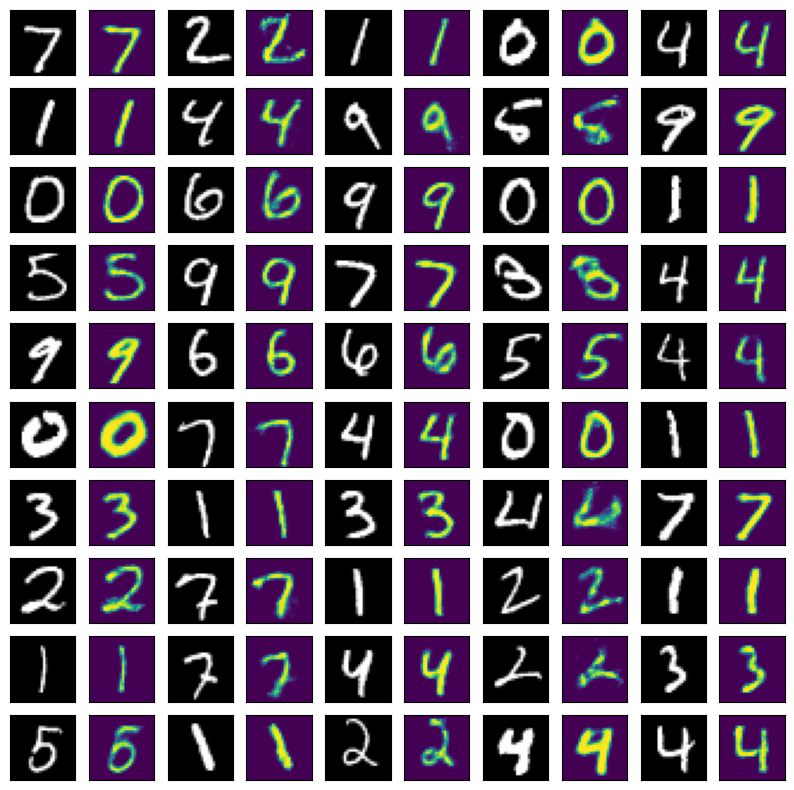

In [8]:
reconstructed_images = updated_model.predict(test_images)

images = []
for i in range(100):
    images.append(test_images[i].reshape(28,28))
    images.append(reconstructed_images[i].reshape(28,28))
rows = 10
cols = 10
plt.figure(figsize=(10,10))
for i in range(rows*cols):
    plt.subplot(rows,cols,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if (i%2 == 0):
        plt.imshow(images[i],cmap='gray')
    else:
        plt.imshow(images[i])
plt.show()

### Test the model on the new test set

1/1 [==============================] - 0s 28ms/step
(1, 784)


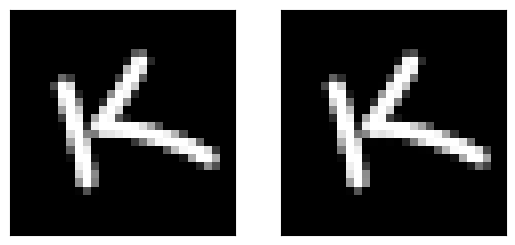

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image


####################################
# load a sample image
image = tf.keras.utils.load_img('newimg_1.png', target_size=(28, 28), color_mode = "grayscale")


####################################
# predict an image from this sample
input_arr = tf.keras.utils.img_to_array(image)
input_arr = input_arr/ 255 # normalize between 0 and 1
input_arr = input_arr.reshape(784)
input_arr = np.array([input_arr])  # Convert single image to a batch with one image in it

predictions = updated_model.predict(input_arr)
print(predictions.shape)


#####################################
# display the two images side by side
# 
plt.subplot(1,2,1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(image, cmap="gray")


plt.subplot(1,2,2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(predictions[0].reshape(28,28), cmap="gray")


plt.show()


In [10]:
updated_model.save('final_trained_autoencoder.h5')

### Summary 

Clearly, there is a marked difference in the prediction after training the pre-trained model with oversampled copies of 5 new images and just a subset of original dataset(digits). This idea of utilizing the previously trained models to train new data is a great advantage in reducing the computation time.